In [1]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [13]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
  'font.size': 8,
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'pgf.texsystem': "pdflatex",
  'pgf.preamble': r'\usepackage{amsfonts}',
  #"font.family": "serif",
  #"pgf.rcfonts": False,
})

In [2]:
fig_width=6
fig_height=1.5
compiler="clang++13.0.1"

throughput_key="items_per_second"
hash_key="hash"
reducer_key="reducer"
order_key="order"
bits_key="bits"
dataset_key="dataset"
dataset_size_key="dataset_size"
buckets_key="buckets"

In [8]:
def hashfn_name(h):
    return {'MultFibonacci32': "Fibonacci",
        'MultFibonacci64': "Fibonacci",
        'MultFibonacciPrime32': "FibonacciPrime",
        'MultFibonacciPrime64': "FibonacciPrime",
        'MultHash32': "Multiplicative",
        'MultHash64': "Multiplicative",
        'aqua0_32': "AquaHash",
        'aqua0_64': "AquaHash",
        'city32': "CityHash",
        'city64': "CityHash",
        'meow32': "MeowHash",
        'meow64_low': "MeowHash",
        'murmur_finalizer32': "Murmur3",
        'murmur_finalizer64': "Murmur3",
        'tabulation32': "Tabulation",
        'tabulation64': "Tabulation",
        'xxh3_32': "XXHash",
        'xxh3_64': "XXHash"}[h]

def bits(h):
    if h in {'MultFibonacci32',
                'MultFibonacciPrime32',
                'MultHash32',
                'aqua0_32',
                'city32',
                'meow32',
                'murmur_finalizer32',
                'tabulation32',
                'xxh3_32'}:
        return 32
    return 64

def reducer_name(r):
    return {None: "None",
            'branchless_fast_modulo32': "Branchless Fast Modulo",
            'branchless_fast_modulo64': "Branchless Fast Modulo",
            'do_nothing32': "Identity",
            'do_nothing64': "Identity",
            'fast_modulo32': "Fast Modulo",
            'fast_modulo64': "Fast Modulo",
            'fastrange32': "Fastrange",
            'fastrange64': "Fastrange",
            'modulo32': "Modulo",
            'modulo64': "Modulo"}[r]

def dataset_name(d):
    return {'books': "amazon", 
            'fb': "facebook", 
            'gap_10': "gapped 10%",
            'osm': "open street map",
            'seq': "sequential",
            'uniform': "uniform",
            'wiki': "wikipedia"}[d]

def do_order(h):
    return {n: i for i, n in enumerate([
        'MultFibonacci32',
        'MultFibonacci64',
        'MultFibonacciPrime32',
        'MultFibonacciPrime64',
        'MultHash32',
        'MultHash64',
        'aqua0_32',
        'aqua0_64',
        'murmur_finalizer32',
        'murmur_finalizer64',
        'xxh3_32',
        'xxh3_64',
        'city32',
        'city64',
        'tabulation32',
        'tabulation64',
        'meow32',
        'meow64_low'])}[h]

In [9]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [10]:
results_file = f"bench_{compiler}.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [11]:
th_df = df[(df["run_type"] == "aggregate") & (df["name"].str.startswith("throughput/")) & (df["aggregate_name"] == "median")].copy(deep=True)
th_df[hash_key] = th_df["label"].apply(lambda x : x.split(":")[0])
th_df[order_key] = th_df[hash_key].apply(do_order)
th_df[bits_key] = th_df[hash_key].apply(bits)
th_df[reducer_key] = th_df.apply(lambda x : x["label"].split(":")[1] if x["label"].count(":") == 2 else f"do_nothing{x[bits_key]}", axis=1)
set(th_df[reducer_key])

sc_df = df[(df["name"].str.startswith("scattering/"))].copy(deep=True)
sc_df[hash_key] = sc_df["label"].apply(lambda x : x.split(":")[0])
sc_df[order_key] = sc_df[hash_key].apply(do_order)
sc_df[bits_key] = sc_df[hash_key].apply(bits)
sc_df[reducer_key] = sc_df.apply(lambda x : x["label"].split(":")[1] if x["label"].count(":") == 3 else f"do_nothing{x[bits_key]}", axis=1)
sc_df[buckets_key] = sc_df["label"].apply(lambda x : x.split(":")[-1])
sc_df[dataset_key] = sc_df["label"].apply(lambda x : x.split(":")[-2])

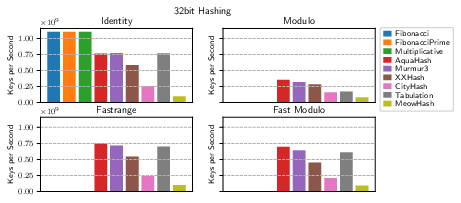

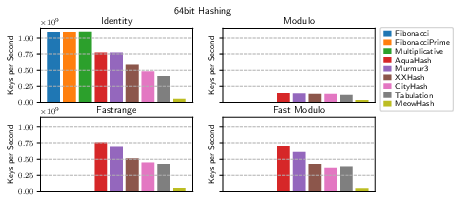

In [20]:
def plot_throughput(data, bits):
    reset_colors()
    
    cols = 2
    rows = 2
    fig, axs = plt.subplots(cols, rows, figsize=(fig_width, fig_height*rows), sharex=True, sharey=True)

    reducers =  {f'do_nothing{bits}': 0, f'modulo{bits}': 1, f'fastrange{bits}': 2, f'fast_modulo{bits}': 3}
    data = data[data[reducer_key].isin(reducers)].copy(deep=True)
    data[reducer_key] = pd.Categorical(data[reducer_key], reducers.keys())
    data = data.sort_values(by=[reducer_key, throughput_key], key=lambda x: x.map(reducers))
    for i, (reducer, df) in enumerate(data.groupby([reducer_key], sort=False)):
        ax = axs[int(i / cols)][i % rows]
        
        ax.set_title(reducer_name(reducer), pad=4)
        ax.set_ylabel("Keys per Second")
        ax.set_yticks(np.arange(0, 1.5 * 10**9, 0.25 * 10**9))
        ax.tick_params(
            axis='x',
            which='both',
            top=False, 
            bottom=False, 
            labelbottom=False)
        ax.grid(linestyle="--", axis="y")

        df = df.sort_values(by=[order_key])
        for j, (name, d) in enumerate(df.groupby([hash_key], sort=False)):
            ax.bar(data=d, x=j if i == 0 else j+3, label=hashfn_name(name), color=get_color(name), height=throughput_key)
            
    # legend in top right plot
    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='center right',
               bbox_to_anchor=(1.09, 0.69),
               ncol=1, 
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=1.0
              )
    
    # overall title
    fig.suptitle(f"{bits}bit Hashing")
    
    fig.savefig(f"throughput_{compiler}_{bits}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"throughput_{compiler}_{bits}.pgf", bbox_inches="tight", dpi=300)

plt.close('all')
plot_throughput(th_df, 32)
plot_throughput(th_df, 64)

In [9]:
def plot_scatters(data, bits):
    reset_colors()
    
    rows = 7
    cols = 3
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width, rows*fig_height*0.7), sharex=True, sharey=True)
    reducers =  {f'do_nothing{bits}': 0, f'fastrange{bits}': 1, f'modulo{bits}': 2}
    data = data[data[reducer_key].isin(reducers)].copy(deep=True)
    data[reducer_key] = pd.Categorical(data[reducer_key], reducers.keys())
    data = data.sort_values(by=[reducer_key, throughput_key], key=lambda x: x.map(reducers))
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset_name(dataset), 
            xy=(0, 0.5), 
            xytext=(110 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='right', 
            va='center',
            rotation=-90
        )
        axs[i][0].set_ylabel("num entries\n(normalized)")
        
        for j, (reducer, df) in enumerate(df.groupby([reducer_key], sort=False)):            
            ax = axs[i][j]

            ax.set_ylim([0.985, 1.015])
            if i == rows - 1:
                ax.set_xlabel("bucket (0 to 100)")

            for _, baseline in df.iterrows():
                name = baseline[hash_key]
                # if "tabulation" not in name:
                #     continue
                bucket_cnt = int(baseline[buckets_key])
                expected_per_bucket = float(baseline[dataset_size_key])/float(baseline[buckets_key])
                normalized_scatters = [float(baseline[f"bucket_{k}"])/expected_per_bucket for k in range(bucket_cnt)]
                ax.plot(np.arange(0, 100.0, 100.0 / bucket_cnt), normalized_scatters, color=get_color(name), label=hashfn_name(name), linewidth=1.5 if name == "MultFibonacci64" else 1)
            
            if i == 0:
                # ax.set_ylabel("normalized entries per slot")
                ax.annotate(reducer_name(reducer), 
                            xy=(0.5, 1), 
                            xytext=(0, pad), 
                            xycoords='axes fraction', 
                            textcoords='offset points', 
                            size='large', 
                            ha='center', 
                            va='baseline',
                           )
    
    h1, l1 = axs[0][0].get_legend_handles_labels()
    h2, l2 = axs[0][1].get_legend_handles_labels()
    legend = fig.legend(h1+h2, l1+l2, 
               loc='lower center',
               bbox_to_anchor=(0.5, 0.0),
               ncol=4, 
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=1.0
              )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    
    # overall title
    fig.suptitle(f"{bits}bit Hashing", y=0.935, fontweight="bold")
    
    fig.savefig(f"scatter_{bits}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"scatter_{bits}.pgf", bbox_inches="tight", dpi=300)

plt.close('all')
plot_scatters(sc_df, 32)
plot_scatters(sc_df, 64)